<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/Task2_%E8%AE%BA%E6%96%87%E4%BD%9C%E8%80%85%E7%BB%9F%E8%AE%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  任务说明
任务：论文作者统计，统计所有论文作者出现频率Top10的姓名；<br>
任务内容：论文作者的统计、使用 Pandas 读取数据并使用字符串操作；<br>
任务目的：学习 Pandas 的字符串操作；<br>
[github链接(原教程):](https://github.com/datawhalechina/team-learning-data-mining/blob/master/AcademicTrends/Task2%20%E8%AE%BA%E6%96%87%E4%BD%9C%E8%80%85%E7%BB%9F%E8%AE%A1.ipyn)

**主要工作**:<br>
+ 1.统计并可视化了2019年以来CV领域发表论文数量top10的作者
+ 2.统计并可视化了2019年以来CV领域发表论文数量top10的作者姓氏
+ 3.统计并可视化了2019年以来CV领域发表论文数量top10的作者姓氏首字母
+ 4.统计并可视化了2015年以来CV领域发表论文数量top10的第一作者
+ 5.统计并可视化了2015年以来CV领域发表论文数量top10的第一作者姓氏

## 具体代码实现





载入数据

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/') #挂载google drive 加载数据集

Mounted at /content/gdrive/


In [2]:
!cp -f  /content/gdrive/MyDrive/Colab\ Notebooks/arxiv.zip  /content/ 

In [3]:
!unzip -o /content/arxiv.zip #解压

Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


In [1]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

## 读取所有数据

In [2]:
#数据读取
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
                                 'report-no', 'categories', 'license', 'abstract', 'versions',
                                 'update_date', 'authors_parsed'], count=None):
  data= []
  with open(path,'r') as f:
    for idx,line in enumerate(f):
      if idx == count:
        break

      d = json.loads(line)
      d = {col:d[col] for col in columns}  
      data.append(d)

  data = pd.DataFrame(data)

  return data

data = readArxivFile('arxiv-metadata-oai-snapshot.json',['id', 'authors', 'categories', 'update_date','authors_parsed'])

      

In [3]:
data["year"] = pd.to_datetime(data["update_date"]).dt.year #将update_date从例如2019-02-20的str变为datetime格式，并提取处year
del data["update_date"] #删除 update_date特征，
data3 = data[data["year"] >= 2019] #找出 year 中2019年以后的数据，并将其他数据删除
data3.head() #查看结果

,id,authors,categories,authors_parsed,year
296,0704.0297,"Sung-Chul Yoon, Philipp Podsiadlowski and Step...",astro-ph,"[[Yoon, Sung-Chul, ], [Podsiadlowski, Philipp,...",2019
341,0704.0342,B. Dugmore and PP. Ntumba,math.AT,"[[Dugmore, B., ], [Ntumba, PP., ]]",2019
359,0704.0360,T.V. Zaqarashvili and K Murawski,astro-ph,"[[Zaqarashvili, T. V., ], [Murawski, K, ]]",2019
524,0704.0525,"Sezgin Aygun, Ismail Tarhan, Husnu Baysal",gr-qc,"[[Aygun, Sezgin, ], [Tarhan, Ismail, ], [Baysa...",2019
534,0704.0535,"Antonio Pipino (1,3), Thomas H. Puzia (2,4), a...",astro-ph,"[[Pipino, Antonio, ], [Puzia, Thomas H., ], [M...",2019


##筛选cv领域2019年之后的论文

In [23]:
data2 = data[data['categories'].apply(lambda x : 'cs.CV' in x)] # 选择类别为cs.CV下面的论文
data2 = data2[data2["year"] >= 2019]
data2

,id,authors,categories,authors_parsed,year
48709,0802.1412,Mahesh Pal,cs.NE cs.CV,"[[Pal, Mahesh, ]]",2019
122831,0905.1235,"Serguei A. Mokhov, Stephen Sinclair, Ian Cl\'e...",cs.SD cs.CL cs.CV cs.MM cs.NE,"[[Mokhov, Serguei A., , for the MARF R&D Group...",2019
274867,1107.2875,"Chris Aholt, Bernd Sturmfels, Rekha Thomas",math.AG cs.CV,"[[Aholt, Chris, ], [Sturmfels, Bernd, ], [Thom...",2019
288218,1109.3850,Dae-Woong Lee,cs.CV,"[[Lee, Dae-Woong, ]]",2020
292514,1110.1208,"Aman Chadha, Divya Jyoti, M. Mani Roja",cs.CV cs.CR cs.IT cs.MM eess.IV math.IT,"[[Chadha, Aman, ], [Jyoti, Divya, ], [Roja, M....",2020
...,...,...,...,...,...
1382755,2011.10007,"Yikai Li, Jiayuan Mao, Xiuming Zhang, Bill Fre...",cs.CV cs.LG stat.ML,"[[Li, Yikai, ], [Mao, Jiayuan, ], [Zhang, Xium...",2020
1382776,2011.10028,"Egor Ershov, Alex Savchik, Illya Semenkov, Nik...",cs.CV,"[[Ershov, Egor, ], [Savchik, Alex, ], [Semenko...",2020
1382781,2011.10033,"Xinge Zhu, Hui Zhou, Tai Wang, Fangzhou Hong, ...",cs.CV,"[[Zhu, Xinge, ], [Zhou, Hui, ], [Wang, Tai, ],...",2020
1382787,2011.10039,"Songwei Ge, Vedanuj Goswami, C. Lawrence Zitni...",cs.CV cs.AI,"[[Ge, Songwei, ], [Goswami, Vedanuj, ], [Zitni...",2020


In [24]:
data2['authors_parsed'].head()

48709                                     [[Pal, Mahesh, ]]
122831    [[Mokhov, Serguei A., , for the MARF R&D Group...
274867    [[Aholt, Chris, ], [Sturmfels, Bernd, ], [Thom...
288218                                 [[Lee, Dae-Woong, ]]
292514    [[Chadha, Aman, ], [Jyoti, Divya, ], [Roja, M....
Name: authors_parsed, dtype: object

## 数据预处理步骤
在原始arxiv数据集中论文作者authors字段是一个字符串格式，其中每个作者使用逗号进行分隔分，所以我们我们首先需要进行预处理：
+ 使用逗号对作者进行切分；
+ 剔除单个作者中非常规的字符；


```
C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan

# 切分为，其中\\为转义符

C. Ba'lazs
E. L. Berger
P. M. Nadolsky
C.-P. Yuan
```

原始数据集中authors_parsed字段已经帮我们处理好了作者信息，可以直接使用该字段完成后续统计。


## 数据统计
接下来我们将完成以下统计操作：

统计所有作者姓名出现频率的Top10；<br>
统计所有作者姓（姓名最后一个单词）的出现频率的Top10；<br>
统计所有作者姓第一个字符的频率；<br>

## 使用sum 拼接list


```

a = [[1], [2], [3], [4], [5]] 
 
sum(a, [])  
# [1, 2, 3, 4, 5]

>>> a = [[1,2],[3],[4,5,6,7],[8]]
>>> sum(a,[])
[1, 2, 3, 4, 5, 6, 7, 8]
```



In [25]:
# 拼接所有作者

all_authors = sum(data2['authors_parsed'], [])

处理完成后all_authors变成了所有一个list，其中每个元素为一个作者的姓名。

## 完成姓名频率的统计。

In [ ]:
# 拼接所有的作者
authors_names = [' '.join(x) for x in all_authors]
print(authors_names)

In [27]:
authors_names = pd.DataFrame(authors_names)
print(authors_names)

                                                       0
0                                            Pal Mahesh 
1              Mokhov Serguei A.  for the MARF R&D Group
2               Sinclair Stephen  for the MARF R&D Group
3                    Clément Ian  for the MARF R&D Group
4       Nicolacopoulos Dimitrios  for the MARF R&D Group
...                                                  ...
123714                                       Lin Yutong 
123715                                      Zhang Zheng 
123716                                          Cao Yue 
123717                                      Lin Stephen 
123718                                           Hu Han 

[123719 rows x 1 columns]


## 自2019年以来CV领域发表论文数量前十名作者

Text(0.5, 1.0, 'Top 10 authors in the number of papers in the CV field since 2019')

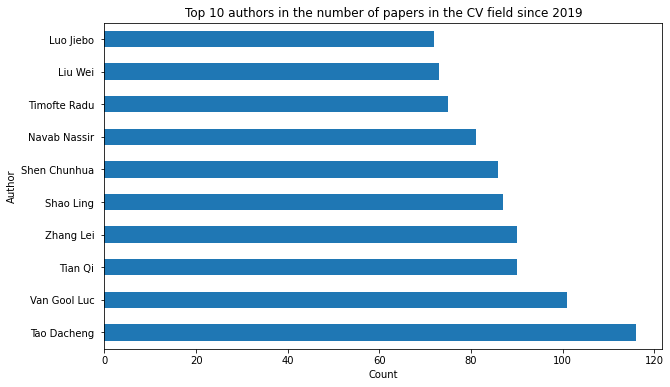

In [29]:
# 根据作者频率绘制直方图
plt.figure(figsize=(10, 6))
authors_names[0].value_counts().head(10).plot(kind='barh')
# 修改图配置
names = authors_names[0].value_counts().index.values[:10]
_ = plt.yticks(range(0, len(names)), names)
plt.ylabel('Author')
plt.xlabel('Count')
plt.title('Top 10 authors in the number of papers in the CV field since 2019')

接下来统计姓名姓，也就是authors_parsed字段中作者第一个单词：

In [30]:
authors_lastnames = [x[0] for x in all_authors]
authors_lastnames = pd.DataFrame(authors_lastnames)
print(authors_lastnames)

                     0
0                  Pal
1               Mokhov
2             Sinclair
3              Clément
4       Nicolacopoulos
...                ...
123714             Lin
123715           Zhang
123716             Cao
123717             Lin
123718              Hu

[123719 rows x 1 columns]


## 自2019年以来CV领域发表论文数量前十的姓氏

Text(0.5, 1.0, 'The top 10 last names in the number of papers in the CV field since 2019')

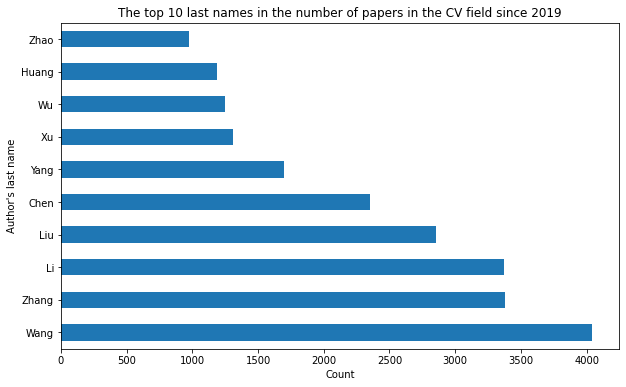

In [75]:
plt.figure(figsize=(10, 6))
authors_lastnames[0].value_counts().head(10).plot(kind='barh')

names = authors_lastnames[0].value_counts().index.values[:10]
_ = plt.yticks(range(0, len(names)), names)
plt.ylabel('Author\'s last name')
plt.xlabel('Count')
plt.title('The top 10 last names in the number of papers in the CV field since 2019')

## 统计所有作者姓第一个字符的频率  2019以来

In [33]:
authors_first_letter = [x[0][0:1] for x in all_authors]
print(authors_first_letter)
authors_first_letter = pd.DataFrame(authors_first_letter)
print(authors_first_letter)

['P', 'M', 'S', 'C', 'N', 'A', 'S', 'T', 'L', 'C', 'J', 'R', 'J', 'C', 'V', 'R', 'C', 'V', 'R', 'N', 'W', 'B', 'B', 'S', 'T', 'R', 'V', 'G', 'G', 'W', 'B', 'S', 'H', 'G', 'B', 'R', 'V', 'O', 'Q', 'F', 'S', 'C', 'M', 'J', 'X', 'X', 'M', 'C', 'C', 'L', 'N', 'H', 'F', 'C', 'G', 'N', 'W', 'Z', 'Z', 'Z', 'S', 'Z', 'G', 'T', 'G', 'L', 'S', 'T', 'L', 'S', 'T', 'S', 'S', 'T', 'P', 'L', 'S', 'L', 'L', 'S', 'V', 'V', 'V', 'C', 'L', 'C', 'H', 'Y', 'D', 'P', 'L', 'S', 'Z', 'C', 'G', 'M', 'S', 'R', 'L', 'L', 'C', 'v', 'A', 'G', 'C', 'V', 'V', 'W', 'J', 'B', 'B', 'C', 'H', 'J', 'L', 'S', 'G', 'L', 'L', 'L', 'G', 'S', 'L', 'C', 'W', 'L', 'L', 'Z', 'T', 'R', 'M', 'd', 'M', 'S', 'C', 'V', 'O', 'T', 'B', 'K', 'K', 'L', 'L', 'C', 'L', 'Z', 'W', 'L', 'P', 'L', 'Y', 'R', 'S', 'V', 'F', 'S', 'A', 'F', 'R', 'F', 'M', 'S', 'N', 'B', 'R', 'T', 'V', 'B', 'P', 'H', 'A', 'S', 'F', 'I', 'B', 'P', 'B', 'P', 'G', 'B', 'G', 'H', 'S', 'O', 'R', 'S', 'V', 'C', 'H', 'L', 'O', 'M', 'T', 'K', 'T', 'V', 'T', 'V', 'M', 'D',

Text(0.5, 0, 'Count')

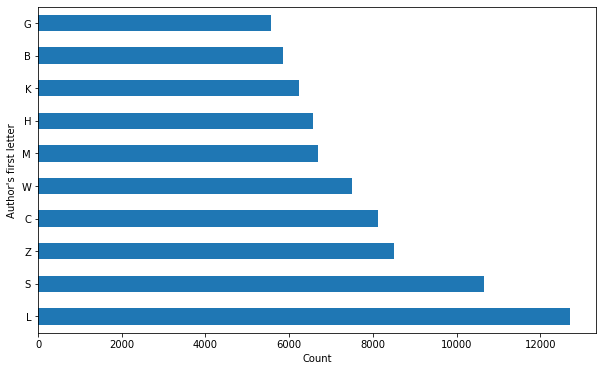

In [34]:
plt.figure(figsize=(10, 6))
authors_first_letter[0].value_counts().head(10).plot(kind='barh')

first_letter = authors_first_letter[0].value_counts().index.values[:10]
_ = plt.yticks(range(0, len(first_letter)), first_letter)
plt.ylabel('Author\'s first letter')
plt.xlabel('Count')


## 统计2015年以来第一作者的信息

In [37]:
data3 = data[data["year"] >= 2015] #找出 year 中2015年以后的数据，
data3 = data3[data3['categories'].apply(lambda x : 'cs.CV' in x)]
data3.head() #查看结果

,id,authors,categories,authors_parsed,year
7671,0705.3669,Donald A. Sofge,cs.NE cs.CV cs.SD,"[[Sofge, Donald A., ]]",2016
8656,0705.4654,Peter F. Lichtenwalner and Donald A. Sofge,cs.SD cs.CV,"[[Lichtenwalner, Peter F., ], [Sofge, Donald A...",2015
27683,0710.0736,David A Kay (Oxford University Computational L...,cs.CV cs.NA,"[[Kay, David A, , Oxford University Computatio...",2018
33676,0711.0784,Philip B. Alipour,cs.CV cs.CE,"[[Alipour, Philip B., ]]",2016
40791,0712.2870,"Hari Palaiyanur, Cheng Chang and Anant Sahai",cs.IT cs.CV math.IT,"[[Palaiyanur, Hari, ], [Chang, Cheng, ], [Saha...",2016


### 提取2015年以来第一作者姓名

In [53]:
first_author = []
for s in data3['authors_parsed']: 
  first_author.append(s[0])
len(first_author)

45722

In [63]:
first_author[:10]

[['Sofge', 'Donald A.', ''],
 ['Lichtenwalner', 'Peter F.', ''],
 ['Kay', 'David A', '', 'Oxford University Computational Laboratory'],
 ['Alipour', 'Philip B.', ''],
 ['Palaiyanur', 'Hari', ''],
 ['Pal', 'Mahesh', ''],
 ['Bao', 'Forrest Sheng', ''],
 ['Li', 'Qiang', ''],
 ['Avanaki', 'Alireza', ''],
 ['Mokhov', 'Serguei A.', '', 'for the MARF R&D Group']]

此时需要对数据预处理<br>
需要将list每个元素拼接str,获取姓名

In [60]:
first_author_1 = []
for s in first_author:
  tep = ''
  for j in range(len(s)):
    tep = tep  + ' ' + s[j]
    tep.rstrip() #去除字符串右边的空格
  first_author_1.append(tep) 

In [62]:
first_author_1[:10]

[' Sofge Donald A. ',
 ' Lichtenwalner Peter F. ',
 ' Kay David A  Oxford University Computational Laboratory',
 ' Alipour Philip B. ',
 ' Palaiyanur Hari ',
 ' Pal Mahesh ',
 ' Bao Forrest Sheng ',
 ' Li Qiang ',
 ' Avanaki Alireza ',
 ' Mokhov Serguei A.  for the MARF R&D Group']

In [65]:
first_author_names = pd.DataFrame(first_author_1)
first_author_names

,0
0,Sofge Donald A.
1,Lichtenwalner Peter F.
2,Kay David A Oxford University Computational ...
3,Alipour Philip B.
4,Palaiyanur Hari
...,...
45717,McGuire Patrick C.
45718,Bajic Dragana
45719,Miravet Carlos
45720,Frailis Marco


Text(0.5, 1.0, 'Top 10 authors in the number of papers in the CV field since 2015 (first author)')

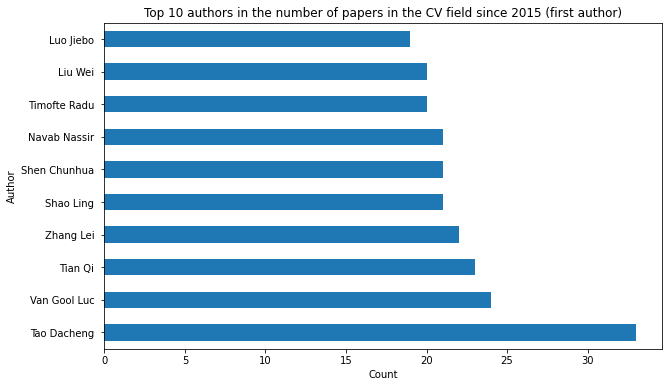

In [67]:
# 根据作者频率绘制直方图
plt.figure(figsize=(10, 6))
first_author_names[0].value_counts().head(10).plot(kind='barh')
# 修改图配置
names = authors_names[0].value_counts().index.values[:10]
_ = plt.yticks(range(0, len(names)), names)
plt.ylabel('Author')
plt.xlabel('Count')
plt.title('Top 10 authors in the number of papers in the CV field since 2015 (first author)')

## 获取2015年以来第一作者姓氏

In [68]:
first_author_lastname = []
for s in first_author:
  first_author_lastname.append(s[0]) 

In [69]:
first_author_lastname[:10]

['Sofge',
 'Lichtenwalner',
 'Kay',
 'Alipour',
 'Palaiyanur',
 'Pal',
 'Bao',
 'Li',
 'Avanaki',
 'Mokhov']

In [70]:
first_author_last_name = pd.DataFrame(first_author_lastname)


In [71]:
first_author_last_name

,0
0,Sofge
1,Lichtenwalner
2,Kay
3,Alipour
4,Palaiyanur
...,...
45717,McGuire
45718,Bajic
45719,Miravet
45720,Frailis


Text(0.5, 1.0, "The top 10 last names in the number of papers in the CV field since 2015(first Author's last names)")

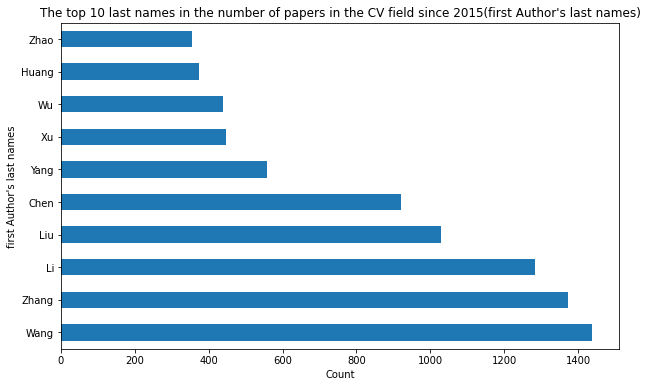

In [74]:
plt.figure(figsize=(10, 6))
first_author_last_name[0].value_counts().head(10).plot(kind='barh')

names = authors_lastnames[0].value_counts().index.values[:10]
_ = plt.yticks(range(0, len(names)), names)
plt.ylabel('first Author\'s last names')
plt.xlabel('Count')
plt.title('The top 10 last names in the number of papers in the CV field since 2015(first Author\'s last names)')